# Handcrafted Feature Extraction: Part-1

### Welcome to the 3rd Lab of 42028: Deep Learning and CNN!

In the 3rd Lab/Tutorial session you will be implementing feature extraction using LBP and HOG and train SVM classifier for classification!

So lets get started!

## Tasks for this week:

1. Extraction of LBP features from fashion MNIST dataset and classification using SVM multiclass classification.
2. Extraction of HOG features from fashion MNIST dataset and classification using SVM multiclass classification.


## Task 1: Extraction of LBP features from fashion MNIST dataset and classification using SVM multiclass classification.

### Step 1: Import required packages



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn import svm # This pacakge is used for svm classification
from sklearn import metrics
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)

###  Mount the Google Drive to access the Fashion MNIST Dataset



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Step 2. Dataset preparation

* ** Utility/Helper function to load Dataset, unzip it and return images and labels.**  (Do not modify)

[**Reference**:   https://github.com/zalandoresearch/fashion-mnist](https:////github.com/zalandoresearch/fashion-mnist)

In [3]:
%cd /content/gdrive/MyDrive/42028 AUT 2024/Week3
!pwd
!unzip data.zip

/content/gdrive/MyDrive/42028 AUT 2024/Week3
/content/gdrive/MyDrive/42028 AUT 2024/Week3
Archive:  data.zip
replace data/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
cd /content/gdrive/MyDrive/42028 AUT 2024/Week3

/content/gdrive/MyDrive/42028 AUT 2024/Week3


In [6]:
ls

 data/
 data.zip
'Handcrafted Feature Extraction_ Part-1-Solution.ipynb'
'Handcrafted Feature Extraction_ Part-2-Solution.ipynb'
 LogisticRegression-NeuralNetwork-Part-1-Solution.ipynb


* **  Use the utility function to load the dataset and split it into train and test.** (Do not change)





In [7]:
X_train, y_train = load_mnist('/content/gdrive/MyDrive/42028 AUT 2024/Week3/data/fashion', kind='train')
X_test, y_test = load_mnist('/content/gdrive/MyDrive/42028 AUT 2024/Week3/data/fashion', kind='t10k')
# initialize the label names from Fashion MNIST github repository

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [8]:
# The 28X28 images are flattened to a feature vector of size 784
# There are 60,000 training examples in the training dataset
# There are 10,000 test sample in the testing dataset
print(np.shape(X_train))
print(np.shape(X_test))

(60000, 784)
(10000, 784)


* ** Reshaping the feature vector back into the 28X28 image**




In [9]:
X_train=X_train.reshape(-1,28,28)
X_test=X_test.reshape(-1,28,28)

# print the size of the result reshaped train and test data splits

print("Train dataset after reshaping:{}".format(np.shape(X_train)))
print("Test dataset after reshaping :{}".format(np.shape(X_test)))

Train dataset after reshaping:(60000, 28, 28)
Test dataset after reshaping :(10000, 28, 28)


### 2. Visualization of Dataset

(Do not change)

top
trouser
sneaker
dress


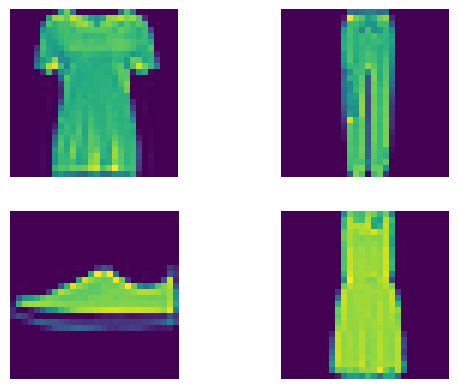

In [10]:
# view few images and print its corresponding label
img_index = 10
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.axis('off')
ax1.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,2)
ax2.axis('off')
img_index = 1000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,3)
ax2.axis('off')
img_index = 20000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])

ax2 = fig.add_subplot(2,2,4)
ax2.axis('off')
img_index = 30000
ax2.imshow(X_train[img_index])
print(labelNames[y_train[img_index]])


### 3. Local Binary Patterns (LBP) class definition for LBP feature extraction

In [11]:
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius

	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
    # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))

		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)

		# return the histogram of Local Binary Patterns
		return hist

**LBP feature extraction for the whole training dataset**

In [12]:
# Create an object of LocalBinaryPatterns class and initial the parameters.
desc = LocalBinaryPatterns(24, 8)
data_train = []
labels_train = []

# loop over the training images
for img_index in range(len(X_train)):
	# load the image, convert it to grayscale, and extract LBP features
	image = (X_train[img_index])
	hist = desc.LBPfeatures(image)

	# extract the label from the image path, then update the
	# label and data lists
	labels_train.append(y_train[img_index])
	data_train.append(hist)

### 4. Train SVM Classifier using the training dataset

***Note: Training process may take long time ...***

In [13]:
# train a SVM clasifier on the training data
# Initialize the SVM model
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
# Start training the SVM classifier
model.fit(data_train, labels_train)

print(np.shape(data_train))
print(np.shape(labels_train))

(60000, 26)
(60000,)


In [14]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(model.score(data_train,labels_train)))

# Expected training set Accuracy 0.60

Train set Accuracy: 0.67


### 5. Evaluation of trained SVM model on test dataset

In [15]:
predictions=[]
predict_label=[]
# Exract LBP features for each test sample and classify it with the trained SVM classifier
for im_index in range(len(X_test)):
  imag = X_test[im_index]
  # Extract LBP feature
  histo = desc.LBPfeatures(imag)
  # Perform classification
  prediction = model.predict(histo.reshape(1, -1))
  # Store the classfication result
  predictions.append(prediction)
  predict_label.append(y_test[im_index])

In [16]:
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.6655


[[686   9  34  64  23  11  46   2  90  35]
 [  1 844  11  49   4  44   0  15  30   2]
 [ 26   0 567   9 198   1 118   0  77   4]
 [ 33  45  21 666  50  34  34  50  38  29]
 [ 15   0 167  54 557   7 132   2  66   0]
 [  5  59   2  11   3 769   0 109  16  26]
 [160   4 207  36 153   7 310   1 109  13]
 [  0  16   0  59   2  37   1 811   8  66]
 [ 61  17  93  33  37  43  44  13 619  40]
 [ 37   2   4  23   3  14   2  67  22 826]]


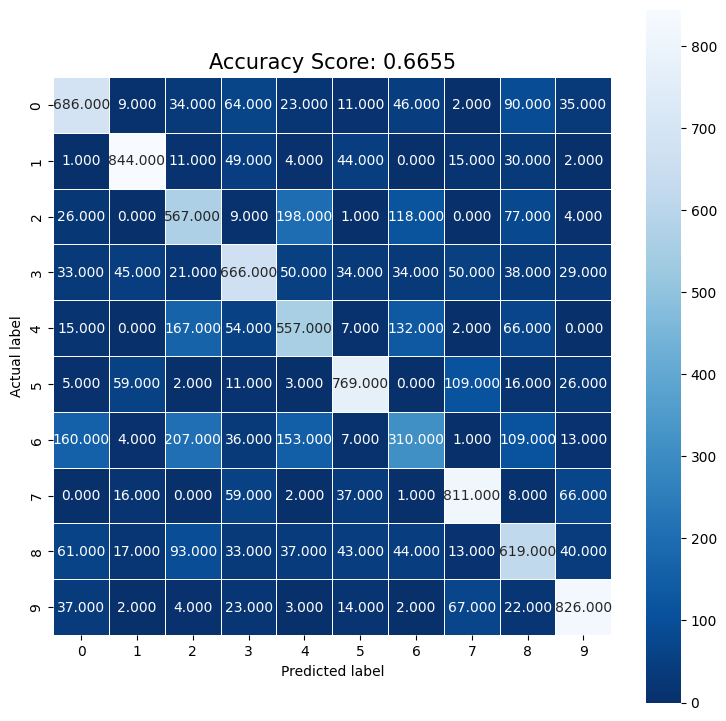

In [17]:
# plot the confusion matrix
cm  = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix using seaborn library
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [18]:
# Display the some classification result on test samples
images = []

# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  # classify the clothing
  histog = desc.LBPfeatures(X_test[i])
  prediction = model.predict(histog.reshape(1, -1))
  label = labelNames[prediction[0]]
  orig_label=labelNames[y_test[i]]
  image = X_test[i]
  color = (0, 255, 0)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
  images.append(image)

In [19]:
np.shape(images[1])

(96, 96, 3)

dress


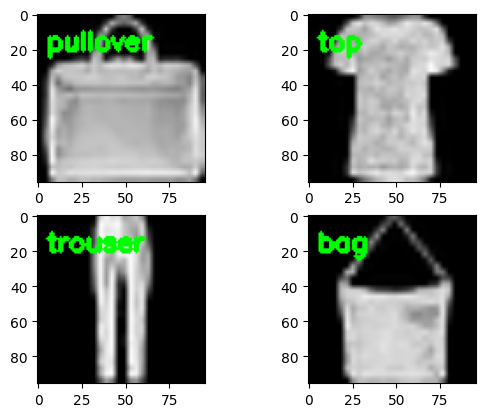

In [20]:
## Display the classification results
#Plot the image and the predicted labels
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[1])
print(orig_label[:])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[4])